In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [25]:
def createDataframes(file_name):
    first_sheet, second_sheet = "Spectres", "Containment"
    df_spectres = pd.read_excel(file_name, sheet_name=first_sheet)
    df_containment = pd.read_excel(file_name, sheet_name=second_sheet)
    df_containment = df_containment.loc[:, ['Влага', 'Клейковина', 'Зольность']]
    np_spectres = df_spectres.loc[:, [name for name in list(df_spectres.columns)[1:]]].to_numpy()
    np_spectres_log = -np.log10(np_spectres)
    print(np_spectres_log)
    df_spectres = pd.DataFrame(np_spectres_log, columns=[wave for wave in range(2400, 1390, -10)])
    return df_spectres, df_containment

def getTrainData(df_y_data, column_name):
    return df_y_data.loc[0:len(df_y_data):2, column_name], df_y_data.loc[1:len(df_y_data):2, column_name]

In [26]:
def plotMlr(actual_data, predicted_data, name):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111)
    axis_x = range(1, len(predicted_data)+1)
    print(predicted_data)
    ax.plot(axis_x, [point for point in predicted_data], color='red', label='Спрогнозированные данные')
    ax.plot(axis_x, [point for point in actual_data], color='blue', label='Актуальные данные')
    ax.scatter(axis_x, predicted_data, color='red')
    ax.scatter(axis_x, actual_data, color='blue')
    plt.legend(loc='upper left')
    plt.xticks([i for i in axis_x])
    plt.xlabel('Номер измерения')
    plt.ylabel('Концентрация исследуемого образца' + ' '+ name)
    plt.show()
    
def calcMlr(actual_data, predicted_data):
    root_mean_square_error = np.sqrt(mean_squared_error(actual_data, predicted_data))
    r2_correlation_value = r2_score(actual_data, predicted_data)
    print(actual_data, predicted_data)
    return root_mean_square_error, r2_correlation_value

def mlrTrain(df_x_data, df_y_data):
    multilinear_model_moist = linear_model.LinearRegression()
    multilinear_model_gluten = linear_model.LinearRegression()
    multilinear_model_ash = linear_model.LinearRegression()
    x_train, x_test = df_x_data.iloc[0:len(df_x_data):2, :], df_x_data.iloc[1:len(df_x_data):2, :]
    print('x train', x_train)
    print('x test', x_test)
    y_train_moisture, y_test_moisture = getTrainData(df_y_data, 'Влага')
    print('y_train_moisture', y_train_moisture)
    print('y_test_moisture', y_test_moisture)
    y_train_gluten, y_test_gluten = getTrainData(df_y_data, 'Клейковина')
    y_train_ash, y_test_ash = getTrainData(df_y_data, 'Зольность')
    multilinear_model_moist.fit(x_train, y_train_moisture)
    multilinear_model_gluten.fit(x_train, y_train_gluten)
    multilinear_model_ash.fit(x_train, y_train_ash)
    y_predict_moisture = multilinear_model_moist.predict(x_test)
    y_predict_gluten = multilinear_model_gluten.predict(x_test)
    y_predict_ash = multilinear_model_ash.predict(x_test)
    plotMlr(actual_data=y_test_moisture, predicted_data=y_predict_moisture, name='влаги')
    plotMlr(actual_data=y_test_gluten, predicted_data=y_predict_gluten, name='клейковины')
    plotMlr(actual_data=y_test_ash, predicted_data=y_predict_ash, name='зольности')
    rmse_moisture, r2_moisture = calcMlr(y_test_moisture, y_predict_moisture)
    rmse_gluten, r2_gluten = calcMlr(y_train_gluten, y_predict_gluten)
    rmse_ash, r2_ash = calcMlr(y_train_ash, y_predict_ash)
    print("СКО для влаги \n", rmse_moisture)
    print("К-т корреляции для влаги: \n", r2_moisture)
    print("СКО для клейковины \n", rmse_gluten)
    print("К-т корреляции для клейковины: \n", r2_gluten)
    print("СКО для зольности \n", rmse_ash)
    print("К-т корреляции для зольности: \n", r2_ash)
    print(r2_score(y_train_ash, y_predict_ash))

In [27]:
def performScaling(df_x_data, df_y_data):
    x_train, x_test = df_x_data.iloc[0:len(df_x_data):2, :], df_x_data.iloc[1:len(df_x_data):2, :]
    std_scale = preprocessing.StandardScaler().fit(x_train)
#     min_max_scale = preprocessing.MinMaxScaler().fit(x_train)
    x_train_scaled, x_test_scaled = std_scale.transform(x_train), std_scale.transform(x_test)
    print(x_train_scaled)
    y_train_moisture, y_test_moisture = getTrainData(df_y_data, 'Влага')
    regr = linear_model.LinearRegression()
    regr.fit(x_train_scaled, y_train_moisture)
    y_pred_moisture = regr.predict(x_test_scaled)
    plotMlr(actual_data=y_test_moisture, predicted_data=y_pred_moisture, name='влаги')
    rmse_moisture, r2_moisture = calcMlr(y_test_moisture, y_pred_moisture)
    print("СКО для влаги \n", rmse_moisture)
    print("К-т корреляции для влаги: \n", r2_moisture)

[[0.37099838 0.37768234 0.38007229 ... 0.78701382 0.86518563 0.9625735 ]
 [0.31318505 0.31957383 0.32184596 ... 0.69637202 0.76802097 0.85667287]
 [0.36171046 0.36855623 0.37110044 ... 0.7780644  0.85604888 0.95428594]
 ...
 [0.38048928 0.38753404 0.39008559 ... 0.80134291 0.88074411 0.97922451]
 [0.37345434 0.38007229 0.38247547 ... 0.79263496 0.86966623 0.96497072]
 [0.39555793 0.40263395 0.40527605 ... 0.82073554 0.90031936 0.99913228]]
x train         2400      2390      2380      2370      2360      2350      2340  \
0   0.370998  0.377682  0.380072  0.380281  0.379344  0.376854  0.373968   
2   0.361710  0.368556  0.371100  0.371407  0.370692  0.368353  0.365221   
4   0.328457  0.334982  0.337242  0.337620  0.336865  0.334513  0.331707   
6   0.316593  0.323032  0.325323  0.325598  0.324955  0.322758  0.319755   
8   0.330497  0.337242  0.339704  0.339989  0.339229  0.336959  0.333857   
10  0.349110  0.356054  0.358427  0.358724  0.358129  0.355758  0.352715   
12  0.373454  0.

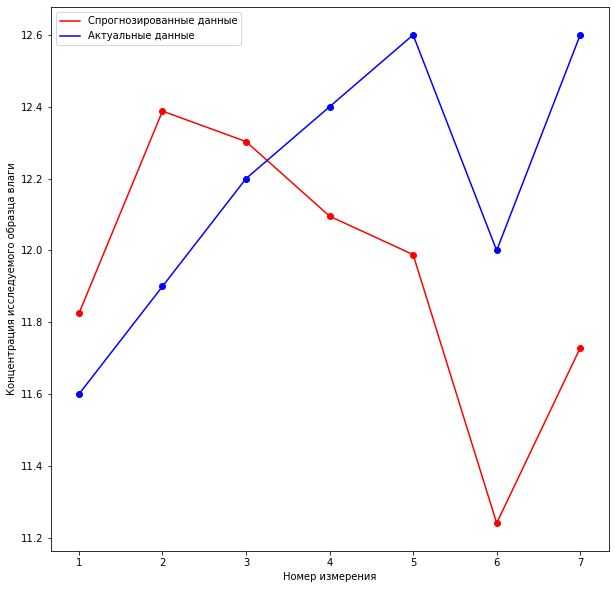

[24.07803601 23.74710569 24.06591061 26.67236638 25.47872025 23.89289337
 26.93074832]


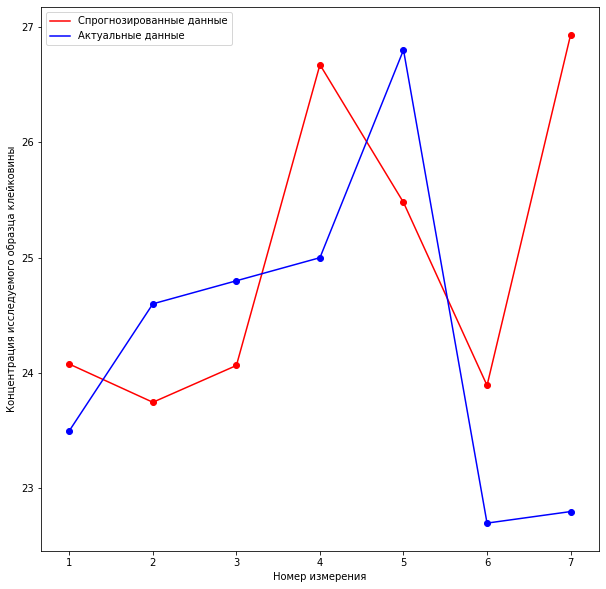

[2.09336367 1.9412584  1.81510422 1.80736558 2.03005585 1.60127632
 1.29526561]


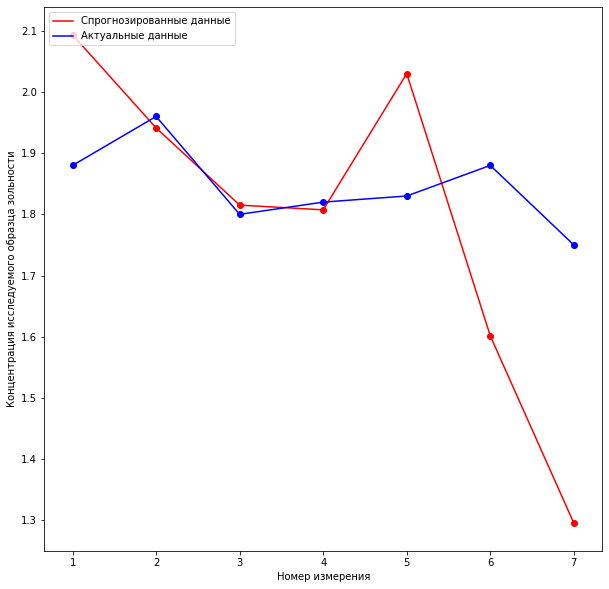

1     11.6
3     11.9
5     12.2
7     12.4
9     12.6
11    12.0
13    12.6
Name: Влага, dtype: float64 [11.82466365 12.38791085 12.30305957 12.09540759 11.98846558 11.24105111
 11.72882199]
0     26.2
2     25.5
4     24.3
6     24.1
8     24.8
10    23.0
12    27.9
Name: Клейковина, dtype: float64 [24.07803601 23.74710569 24.06591061 26.67236638 25.47872025 23.89289337
 26.93074832]
0     1.85
2     1.75
4     1.75
6     1.93
8     1.81
10    1.80
12    1.78
Name: Зольность, dtype: float64 [2.09336367 1.9412584  1.81510422 1.80736558 2.03005585 1.60127632
 1.29526561]
СКО для влаги 
 0.54783436546093
К-т корреляции для влаги: 
 -1.4757579304745816
СКО для клейковины 
 1.5327195652587053
К-т корреляции для клейковины: 
 -0.07140947524771968
СКО для зольности 
 0.2501332550745914
К-т корреляции для зольности: 
 -17.0977899611353
-17.0977899611353
[[ 1.1396813   1.13561364  1.13309881  1.13149433  1.12748219  1.12615049
   1.12859707  1.12932622  1.12673894  1.12568016  1.12843299  1.1

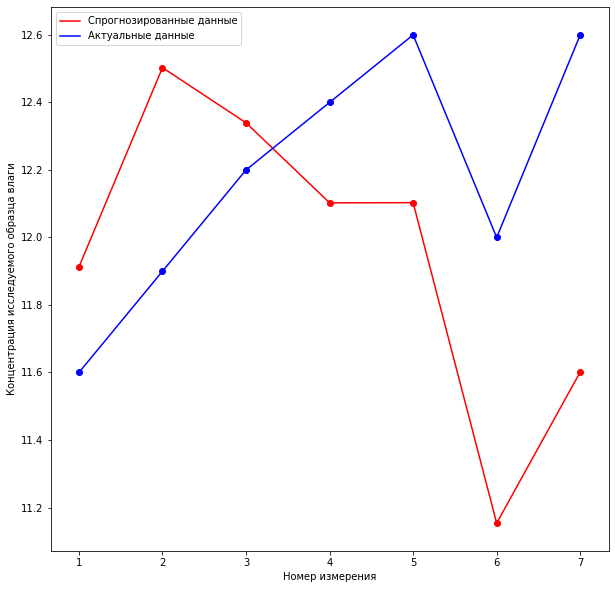

1     11.6
3     11.9
5     12.2
7     12.4
9     12.6
11    12.0
13    12.6
Name: Влага, dtype: float64 [11.91266352 12.50296669 12.33960322 12.10255717 12.10301949 11.15382721
 11.60144364]
СКО для влаги 
 0.6011181762789871
К-т корреляции для влаги: 
 -1.9807760994605723


In [28]:
def main():
    cwd = os.getcwd()
    cwd_wheat = "C:/Users/Alexander/Desktop/диплом"
    os.chdir(cwd_wheat)
    # print(os.listdir())
    file_name_df = "Ставр_данные.xlsx"
    df_spectres, df_containment = createDataframes(file_name_df)
    mlrTrain(df_x_data=df_spectres, df_y_data=df_containment)
    performScaling(df_x_data=df_spectres, df_y_data=df_containment)
#     print(df_spectres, '\n', df_containment)
    

if __name__ == "__main__":
    main()